In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

In [18]:
price_2 = pd.read_csv('r1_data/prices_round_1_day_-2.csv', sep=';')
price_1 = pd.read_csv('r1_data/prices_round_1_day_-1.csv', sep=';')
price_0 = pd.read_csv('r1_data/prices_round_1_day_0.csv', sep=';')

trades_2 = pd.read_csv('r1_data/trades_round_1_day_-2_nn.csv', sep=';')
trades_1 = pd.read_csv('r1_data/trades_round_1_day_-1_nn.csv', sep=';')
trades_0 = pd.read_csv('r1_data/trades_round_1_day_0_nn.csv', sep=';')

all_prices = pd.concat([price_2, price_1, price_0])
all_trades = pd.concat([trades_2, trades_1, trades_0])

prices = {"all": all_prices}
trades = {"all": all_trades}
products = list(all_prices['product'].unique())
for product in products:
    prices[product] = all_prices[all_prices['product'] == product]
    trades[product] = all_trades[all_trades['symbol'] == product]

print(all_prices.columns)
# print(all_trades.columns)
# print(trades['AMETHYSTS'].head())
print(products)

Index(['day', 'timestamp', 'product', 'bid_price_1', 'bid_volume_1',
       'bid_price_2', 'bid_volume_2', 'bid_price_3', 'bid_volume_3',
       'ask_price_1', 'ask_volume_1', 'ask_price_2', 'ask_volume_2',
       'ask_price_3', 'ask_volume_3', 'mid_price', 'profit_and_loss'],
      dtype='object')
['AMETHYSTS', 'STARFRUIT']


In [19]:
prices_exclude_columns = ["day", "timestamp", "product", "profit_and_loss"]
trades_exclude_columns = ["timestamp", "buyer", "seller", "symbol", "currency"]

price_points = set()
for column in ["bid_price_1", "bid_price_2", "bid_price_3", "ask_price_1", "ask_price_2", "ask_price_3"]:
    price_points.update(list(prices["AMETHYSTS"][column].unique()))
print(f"unique price points for amythests: {price_points}\n")

for product in products:
    print(f"{product}")
    p = prices[product].drop(columns=prices_exclude_columns)
    t = trades[product].drop(columns=trades_exclude_columns)

    for column in p.columns:
        print(f"{column}")
        print(p[column].describe())
        print()

    for column in t.columns:
        print(f"{column}")
        print(t[column].describe())
        print()

unique price points for amythests: {nan, nan, nan, 9995, 9996, 9998, 10000, 10002, 10004, 10005, nan}

AMETHYSTS
bid_price_1
count    30000.000000
mean      9996.609633
std          1.937861
min       9995.000000
25%       9995.000000
50%       9996.000000
75%       9996.000000
max      10002.000000
Name: bid_price_1, dtype: float64

bid_volume_1
count    30000.000000
mean         8.218933
std         10.155552
min          0.000000
25%          1.000000
50%          2.000000
75%         20.000000
max         30.000000
Name: bid_volume_1, dtype: float64

bid_price_2
count    22311.000000
mean      9995.290395
std          0.634420
min       9995.000000
25%       9995.000000
50%       9995.000000
75%       9995.000000
max      10000.000000
Name: bid_price_2, dtype: float64

bid_volume_2
count    22311.000000
mean        19.714939
std         10.142682
min          1.000000
25%         20.000000
50%         23.000000
75%         27.000000
max         30.000000
Name: bid_volume_2, dtype: 

## MACHINE LEARNING

In [20]:
import sklearn
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score


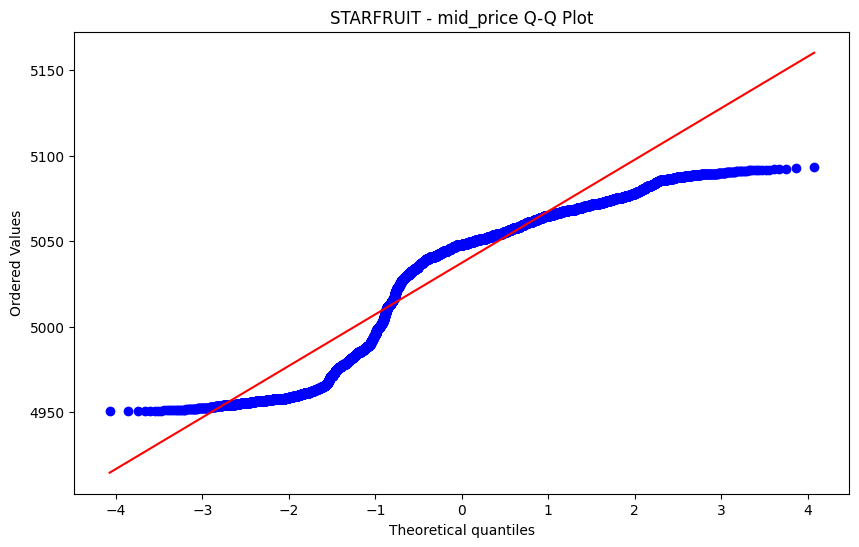

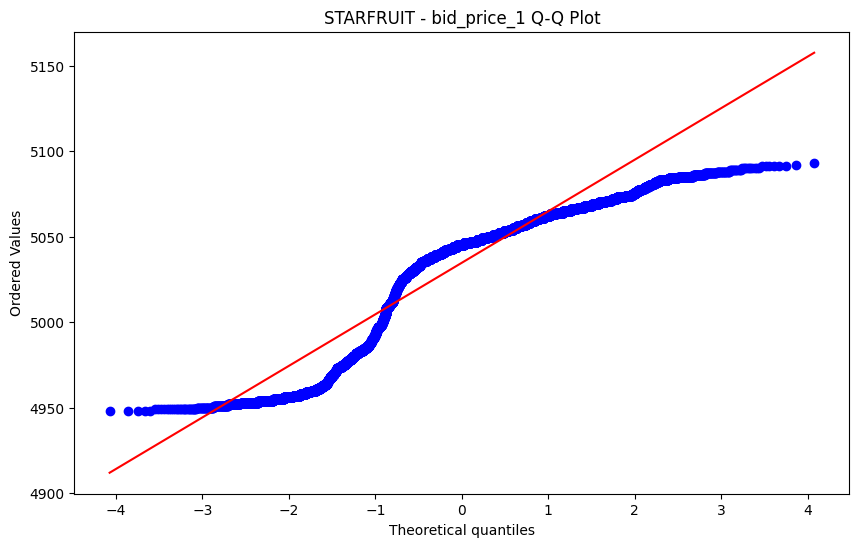

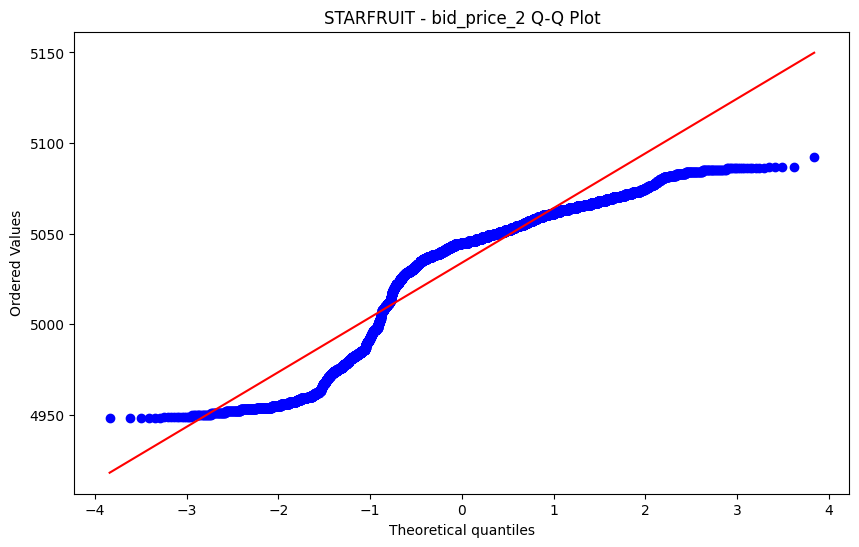

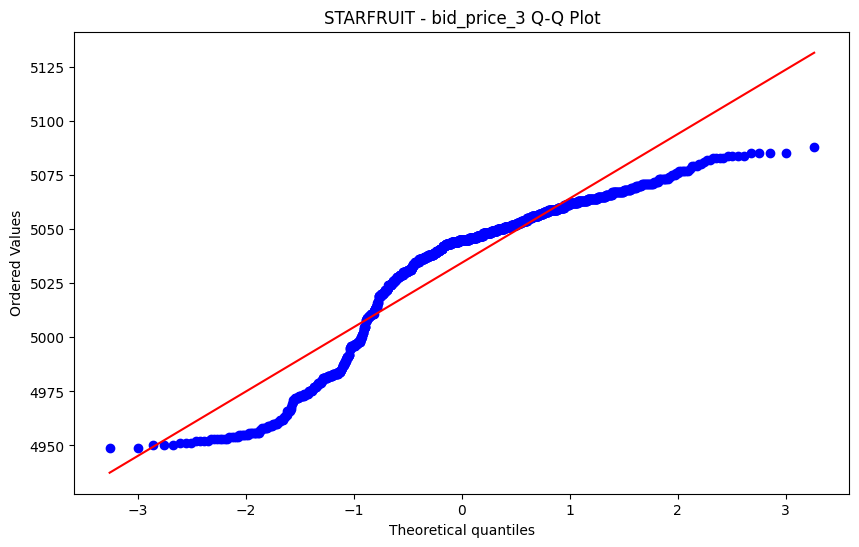

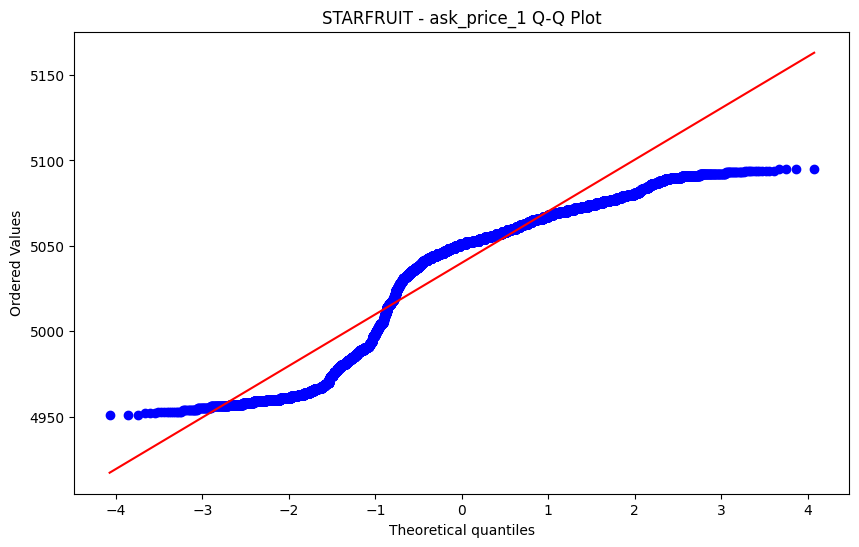

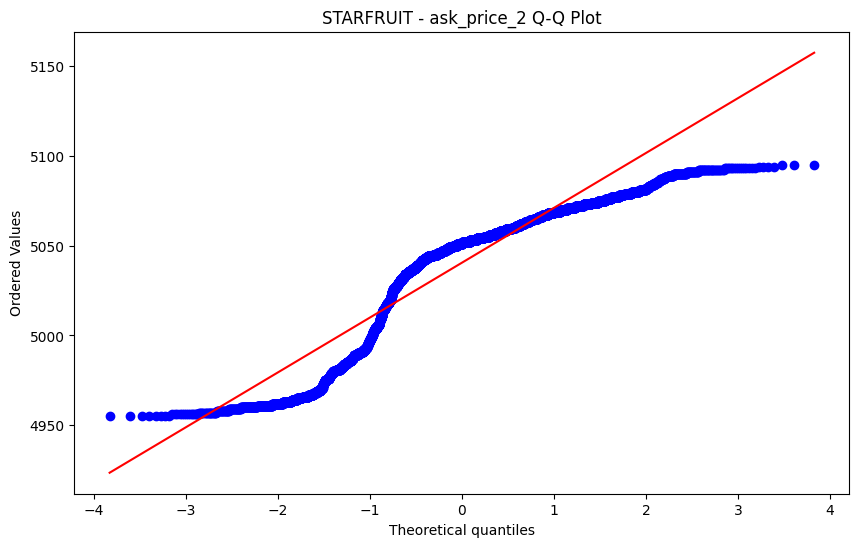

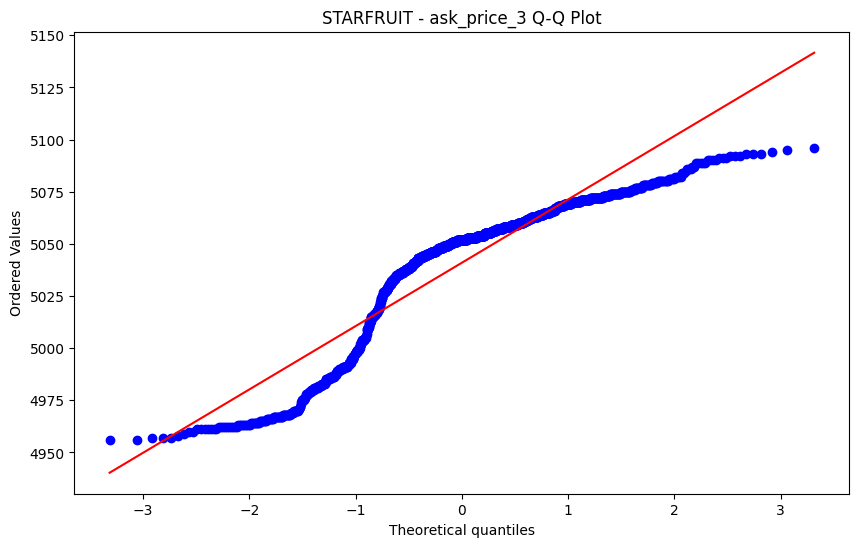

In [21]:
# PLOT DISTRIBUTIONS
price_columns = ["mid_price", "bid_price_1", "bid_price_2", "bid_price_3", "ask_price_1", "ask_price_2", "ask_price_3"]
# for column in ["mid_price", "bid_price_1", "bid_price_2", "bid_price_3", "ask_price_1", "ask_price_2", "ask_price_3"]:
#     plt.figure(figsize=(10, 6))
#     prices["STARFRUIT"].boxplot(column=column)
#     plt.title(f"{"STARFRUIT"} - {column}")
#     plt.show()

# for column in columns:
#     plt.figure(figsize=(10, 6))
#     prices["STARFRUIT"][column].hist(bins=20)
#     plt.title(f"{product} - {column}")
#     plt.xlabel(column)
#     plt.ylabel("Frequency")
#     plt.show()

for column in price_columns:
    plt.figure(figsize=(10, 6))
    stats.probplot(prices["STARFRUIT"][column].dropna(), dist="norm", plot=plt)
    plt.title(f"{product} - {column} Q-Q Plot")
    plt.show()



In [ ]:
# CONFIGS
previous_timesteps = 5
future_timesteps = 0
product = "STARFRUIT"
scaler = MinMaxScaler()
model = Ridge()

In [ ]:
# SCALE DATA
df = prices[product].copy()
df.reset_index(drop=True, inplace=True)
df_scaled = pd.DataFrame(scaler.fit_transform(prices[product][price_columns]), columns=price_columns)
for column in price_columns:
    df[column] = df_scaled[column]

# df.head()

In [ ]:
# FEATURE EXTRACTION
features = pd.DataFrame()

total_bid_volume = (
    df['bid_volume_1'].fillna(0) +
    df['bid_volume_2'].fillna(0) +
    df['bid_volume_3'].fillna(0)
)
total_ask_volume = (
    df['ask_volume_1'].fillna(0) +
    df['ask_volume_2'].fillna(0) +
    df['ask_volume_3'].fillna(0)
)

# Spread: The difference between the ask price and the bid price.
features['spread'] = df['ask_price_1'] - df['bid_price_1']

# Weighted Price: Weighted price for bids and asks
features['weighted_bid_price'] = (
    df['bid_price_1'].fillna(0) * df['bid_volume_1'].fillna(0) +
    df['bid_price_2'].fillna(0) * df['bid_volume_2'].fillna(0) +
    df['bid_price_3'].fillna(0) * df['bid_volume_3'].fillna(0)
) / total_bid_volume

features['weighted_ask_price'] = (
    df['ask_price_1'].fillna(0) * df['ask_volume_1'].fillna(0) +
    df['ask_price_2'].fillna(0) * df['ask_volume_2'].fillna(0) +
    df['ask_price_3'].fillna(0) * df['ask_volume_3'].fillna(0)
) / total_ask_volume

# Volume Imbalance: The difference between total bid volume and total ask volume
features['volume_imbalance'] = total_bid_volume - total_ask_volume

# Depth: Sum of volumes at the best three bid and ask levels.
features['bid_depth'] = total_bid_volume
features['ask_depth'] = total_ask_volume

# Previous Timesteps:
for lag in range(1, previous_timesteps + 1):
    features[f'lag_{lag}'] = df['mid_price'].shift(lag)

# Future Timesteps:
features['future'] = df['mid_price'].shift(-future_timesteps)
features = features.dropna()  # Remove rows with missing values

# print(features.tail())

In [ ]:
X = features.drop(columns=['future'])
y = features['future']

In [ ]:
# TRAIN-TEST SPLIT
split_point = int(len(X) * 0.8)
X_train, X_test = X[:split_point], X[split_point:]
y_train, y_test = y[:split_point], y[split_point:]

In [ ]:
# PREDICTIONS
model.fit(X_train, y_train)
predictions = model.predict(X_test)


In [ ]:
# ERROR

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)
r2 = r2_score(y_test, predictions)
print("R2 Score:", r2)

In [ ]:
# COEFFICIENTS
def plot_coefficients(model, feature_names):
    # Get coefficients and feature names
    coefficients = model.coef_
    names = feature_names
    # Sort coefficients and names by absolute value
    sorted_indices = np.argsort(np.abs(coefficients))[::-1]
    sorted_coefficients = coefficients[sorted_indices]
    sorted_names = [names[i] for i in sorted_indices]
    # Plot
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_names)), sorted_coefficients, align='center')
    plt.yticks(range(len(sorted_names)), sorted_names)
    plt.xlabel('Coefficient Value')
    plt.title('Coefficient Importance')
    plt.show()

    for i, (coef, column) in enumerate(zip(sorted_coefficients, sorted_names)):
        print(f"{column.ljust(20)}: {coef}")

plot_coefficients(model, X.columns)

# Linear
RobustScalar + Linear:
Mean Squared Error: 0.0009404437231691621
R2 Score: 0.9895581738581988

StandardScalar + Linear:
Mean Squared Error: 0.0005373078239915657
R2 Score: 0.993522373208647

MinMax + Linear:
Mean Squared Error: 2.5151512344622413e-05
R2 Score: 0.9940576745038987

# Ridge
RobustScalar + Ridge:
Mean Squared Error: 0.0009059800194848123
R2 Score: 0.9899408272729738

StandardScalar + Ridge:
Mean Squared Error: 0.0005444314958698407
R2 Score: 0.9934364922931809

MinMax + Ridge:
Mean Squared Error: 3.0233345131682666e-05
R2 Score: 0.9928570347919123

# Lasso
RobustScalar + Lasso:
Mean Squared Error: 1.1883322763072461
R2 Score: -12.194153698082859

StandardScalar + Lasso:
Mean Squared Error: 1.2668465944347473
R2 Score: -14.272733941751872

MinMax + Lasso:
Mean Squared Error: 0.06464343909200786
R2 Score: -14.272733941751873

# ElasticNet
RobustScalar + ElasticNet:
Mean Squared Error: 0.3434291930629991
R2 Score: -2.813123356173332

StandardScalar + ElasticNet:
Mean Squared Error: 0.3678735199574861
R2 Score: -3.4349761203986295

MinMax + ElasticNet:
Mean Squared Error: 0.06464343909200786
R2 Score: -14.272733941751873